In [1]:
import pandas as pd

df = pd.read_excel('OnlineRetail.xlsx')

df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [2]:
df = df.dropna(subset=['CustomerID'])

df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
df['TotalPurchase'] = df['Quantity'] * df['UnitPrice']

In [4]:
import datetime as dt

snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

In [5]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalPurchase': 'sum'
})

rfm.rename(columns={'InvoiceDate': 'Recency', 
                    'InvoiceNo': 'Frequency', 
                    'TotalPurchase': 'Monetary'}, inplace=True)

rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40


In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
features = ['Recency', 'Frequency', 'Monetary']

scaler = StandardScaler()

rfm_scaled = scaler.fit_transform(rfm[features])
rfm_scaled = pd.DataFrame(rfm_scaled, columns=features, index=rfm.index)
rfm_scaled.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,2.334574,-0.396578,8.358668
12347.0,-0.905340,0.394649,0.250966
12348.0,-0.175360,-0.265435,-0.028596
12349.0,-0.735345,-0.081836,-0.033012
12350.0,2.174578,-0.326635,-0.191347


In [8]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

C:\Users\iamaa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\iamaa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\iamaa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\iamaa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

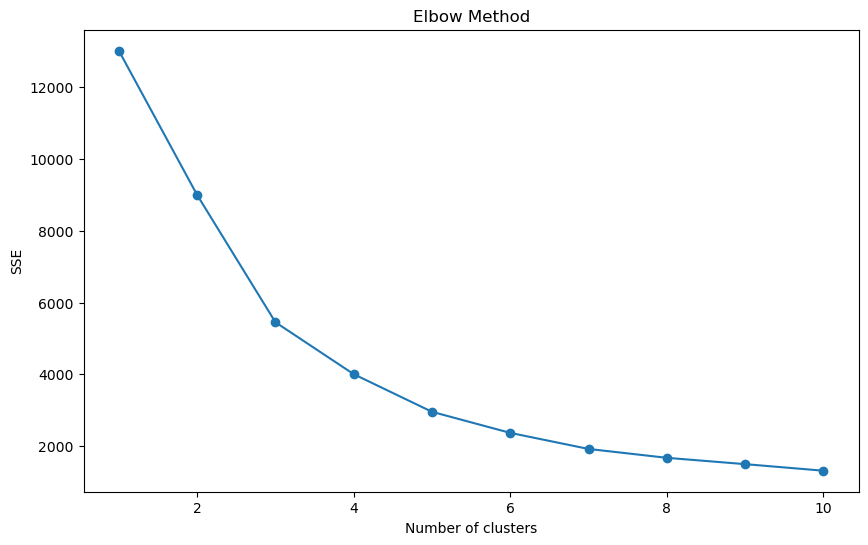

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()

In [10]:
optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

rfm.head()


C:\Users\iamaa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346.0,326,1,77183.60,1
12347.0,2,182,4310.00,0
12348.0,75,31,1797.24,0
12349.0,19,73,1757.55,0
12350.0,310,17,334.40,1


In [11]:
cluster_analysis = rfm.groupby('Cluster').mean()

cluster_analysis['Size'] = rfm['Cluster'].value_counts()

cluster_analysis

,Recency,Frequency,Monetary,Size
Cluster,,,,
0,41.377196,103.089060,2028.833862,3245
1,247.308333,27.787963,637.318510,1080
2,4.692308,2565.307692,126118.310000,13


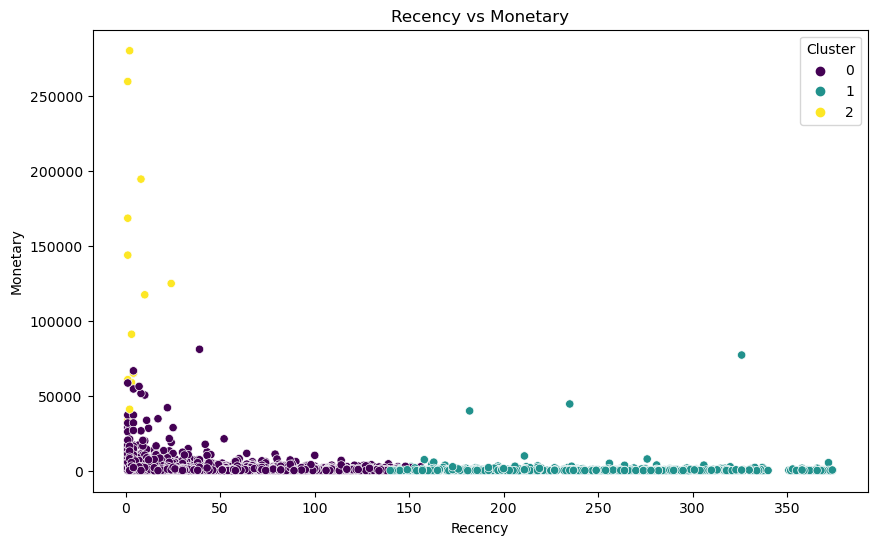

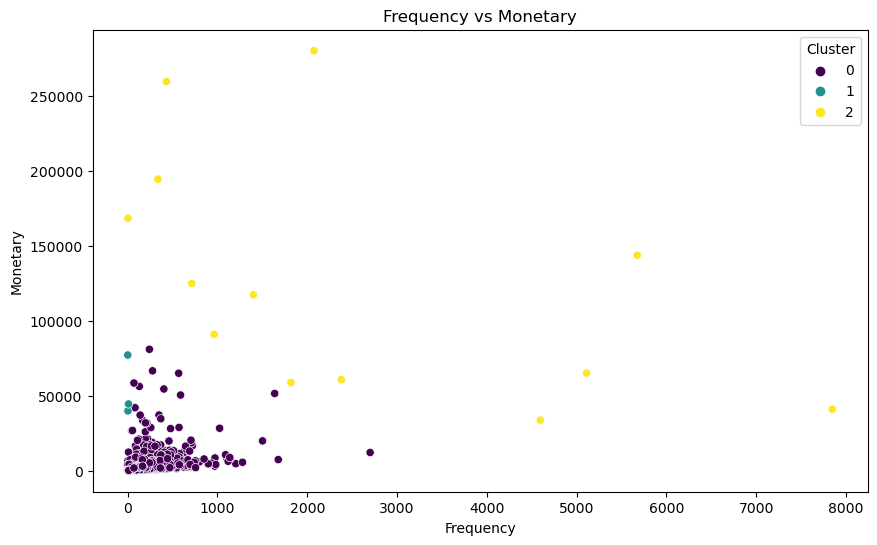

In [12]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Recency', y='Monetary', hue='Cluster', data=rfm, palette='viridis')
plt.title('Recency vs Monetary')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Frequency', y='Monetary', hue='Cluster', data=rfm, palette='viridis')
plt.title('Frequency vs Monetary')
plt.show()

In [13]:
from sklearn.metrics import silhouette_score

score = silhouette_score(rfm_scaled, rfm['Cluster'])
print(f'Silhouette Score: {score}')

Silhouette Score: 0.6019775931686978
